In [31]:
#%pip install scikeras
#%pip uninstall scikit-learn
#%pip install scikit-learn
#%pip install --upgrade tensorflow

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

dt = 0.05

In [2]:
#Funcao que gera os sinais de treino e teste
def Inc_Signals(A_, f_, x_):
    y_ = A_[0]*np.sin(f_[0]*x_)
    for i in range(1, len(A_)):
        y_ = y_ + A_[i]*np.sin(f_[i]*x_) #O sinal eh uma soma de senos de diferentes amplitudes e frequencias

    return y_

#Cria os datasets de tamanho lb (prever lb+1)
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0, 0])
  return np.array(dataX), np.array(dataY)

In [3]:
A = np.array([1, 1, 1])
A = A/np.sum(A)
fs = np.array([1, np.sqrt(5), np.sqrt(11)])

#Funcao que gera os dados de treino
def Gera_Sinal(x_max, lb):
  x = np.arange(0, x_max, dt)

  y = Inc_Signals(A, fs, x)

  y = y.reshape((len(y), 1, 1))

  x_tr, y_tr = create_dataset(y, lb)

  x_tr = x_tr.reshape((len(x_tr), lb, 1, 1))

  return x_tr, y_tr

In [4]:
#Modelo de CNN
def create_model(nNeurons, lb):

    model = keras.models.Sequential()

    model.add(keras.layers.Input((lb, 1, 1)))
    model.add(keras.layers.Conv2D(nNeurons, (8, 1), padding = 'same'))
    model.add(keras.layers.LeakyReLU(negative_slope = 0.01))
    model.add(keras.layers.MaxPooling2D(pool_size = (7, 1)))

    model.add(keras.layers.Conv2D(int(nNeurons/1), (8, 1), padding = 'same'))
    model.add(keras.layers.LeakyReLU(negative_slope = 0.01))
    model.add(keras.layers.MaxPooling2D(pool_size = (5, 1)))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(2*nNeurons))
    model.add(keras.layers.LeakyReLU(negative_slope = 0.01))

    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam', loss = 'mse')

    model.summary()

    return model


In [5]:
def treina_modelo(x_tr, y_tr, nNeurons, lb):

  net = create_model(nNeurons, lb)

  hist = net.fit(x_tr, y_tr, epochs = 50, batch_size = 8, verbose = 0)

  return hist, net

In [6]:
#Extrapolacao autoregressiva
def Autoref_extrap(x_tr, y_tr, model, x_max, nNeurons, lb, npred):

  x_ext = np.arange(x_max, x_max+1000, dt)

  #extrapolation = []

  #print(len(y_tr[:lb]))
  #seed_batch    = y_tr[:lb].reshape((1,lb, 1))
  #current_batch = seed_batch
  #extrapol = []
  #for i in tqdm(range(npred)):
  #    predicted_value = model.predict(current_batch, verbose = 0)[0]
  #    extrapol.append(predicted_value)
  #    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)
  #extrapolation.append(extrapol)
  test_y = y_tr[(-lb):]

  for i in tqdm(range( len(x_ext) - lb )):
    net_input = test_y[i : i + lb]
    net_input = net_input.reshape((1, lb, 1, 1))
    y = model.predict(net_input, verbose=0)
    test_y = np.append(test_y, y)

  results = model.evaluate(x_tr, y_tr, batch_size=8)

  return x_ext, test_y, results#x_ext, np.array(extrapolation)

In [7]:
n_neurons = np.array([8, 16, 32, 64])
xmax = np.array([40, 60, 80, 100])
lbs = np.array([200, 250, 300, 350, 400])
npred = 500

Ys = []
tr_eval = []
for i in range(len(xmax)):
  xtr, ytr = Gera_Sinal(xmax[i], lbs[2])
  print(xtr.shape)
  print(ytr.shape)
  _, modelo = treina_modelo(xtr, ytr, n_neurons[2], lbs[2])
  xext, yext, training_eval = Autoref_extrap(xtr, ytr, modelo, xmax[i], n_neurons[2], lbs[2], npred)
  Ys.append(yext)
  tr_eval.append(training_eval)
  


(499, 300, 1, 1)
(499,)


I0000 00:00:1728566723.697326    8684 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728566726.275311    8684 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728566726.275632    8684 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728566726.277400    8684 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 1, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 1, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 42, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,025 (97.75 KB)

 Trainable params: 25,025 (97.75 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1728566727.959829    8789 service.cc:146] XLA service 0x7fd568004db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728566727.959852    8789 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-10-10 10:25:27.983946: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 10:25:28.393492: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904
I0000 00:00:1728566731.510442    8789 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 19700/19700 [11:36<00:00, 28.28it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4714e-04  
(899, 300, 1, 1)
(899,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 300, 1, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 300, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 1, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 42, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,025 (97.75 KB)

 Trainable params: 25,025 (97.75 KB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 19700/19700 [11:27<00:00, 28.66it/s]


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 9.8147e-04
(1299, 300, 1, 1)
(1299,)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 300, 1, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 300, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 42, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 42, 1, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 42, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,025 (97.75 KB)

 Trainable params: 25,025 (97.75 KB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 19700/19700 [11:57<00:00, 27.47it/s]


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 6.9397e-04
(1699, 300, 1, 1)
(1699,)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 300, 1, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 300, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 42, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 42, 1, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 42, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,025 (97.75 KB)

 Trainable params: 25,025 (97.75 KB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 19700/19700 [11:23<00:00, 28.81it/s]


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.0013  


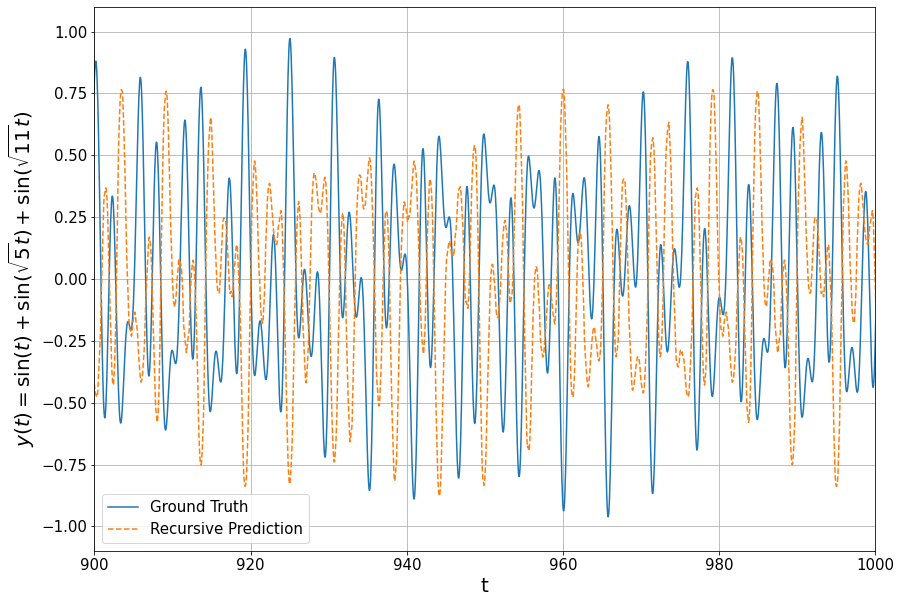

In [97]:
Ys = np.array(Ys)

LB = 300

Npoints_pred = 20000

#print(len(Ys[0, 0, :, 0]))
mae = []
for i in range(len(xmax)):
  x0 = np.arange(0, xmax[i]+Npoints_pred*dt, dt)#- lb*0.05
  x_extrapol = np.arange(xmax[i], xmax[i]+Npoints_pred*dt-LB*dt, dt)

  y0= Inc_Signals(A, fs, x0)
  y_new= Inc_Signals(A, fs, x_extrapol)

  #print(np.sum((Ys[i, 0, :, 0]-y_new)**2)/len(y_new))
  mae.append(np.sum((Ys[i, -(len(Ys[i])-LB):]-y_new)**2)/len(y_new))
  if i == 3:
    x_ext = np.arange(xmax[i]-LB*dt, xmax[i]+Npoints_pred*dt-LB*dt, dt)
    #print(len(Ys[i, 0, :, 0]))
    #print(len(x_extrapol))
    with plt.rc_context({'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
      fig = plt.figure(figsize = (14, 10))
      plt.plot(x0, y0, label = 'Ground Truth')
      plt.plot(x_extrapol , Ys[i, -(len(Ys[i])-LB):], linestyle = 'dashed', label = 'Recursive Prediction')

      plt.xlim(9*xmax[i], 10*xmax[i])
      plt.axvline(x = xmax[i], c = 'black')


plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$y(t) = \sin(t)+\sin(\sqrt{5}t) + \sin(\sqrt{11}t)$', fontsize = 20)

plt.tick_params(labelsize = 15)

plt.grid(visible = True)

plt.legend(fontsize = 15)

#plt.savefig('fig1_6.png', format = 'png', bbox_inches = 'tight')

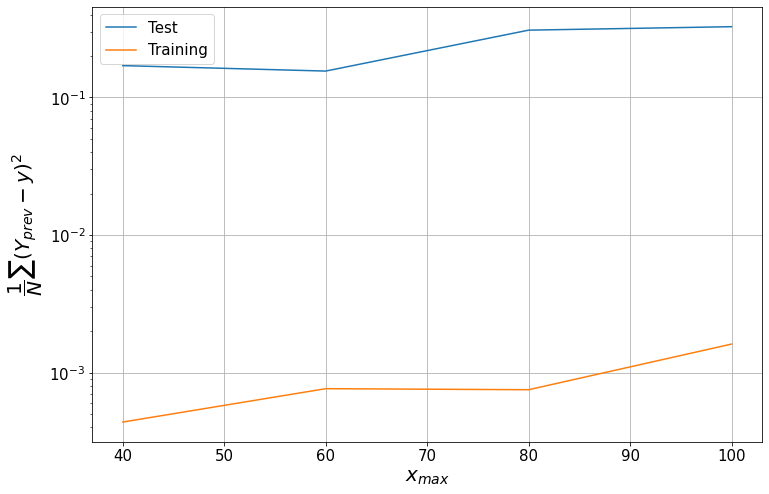

In [ ]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    plt.figure(figsize = (12, 8))

    plt.semilogy(xmax, mae, label = r'Test')
    plt.semilogy(xmax, tr_eval, label = r'Training')
    plt.xlabel(r'$t_{max}$', fontsize = 20)
    plt.ylabel(r'$\dfrac{1}{N}\sum(Y_{prev}-y)^2$', fontsize = 20)
    plt.tick_params(labelsize = 15)

    plt.grid(visible = True)

    plt.legend(fontsize = 15)

    #plt.savefig('fig1_7.png', format = 'png', bbox_inches = 'tight')

plt.show()

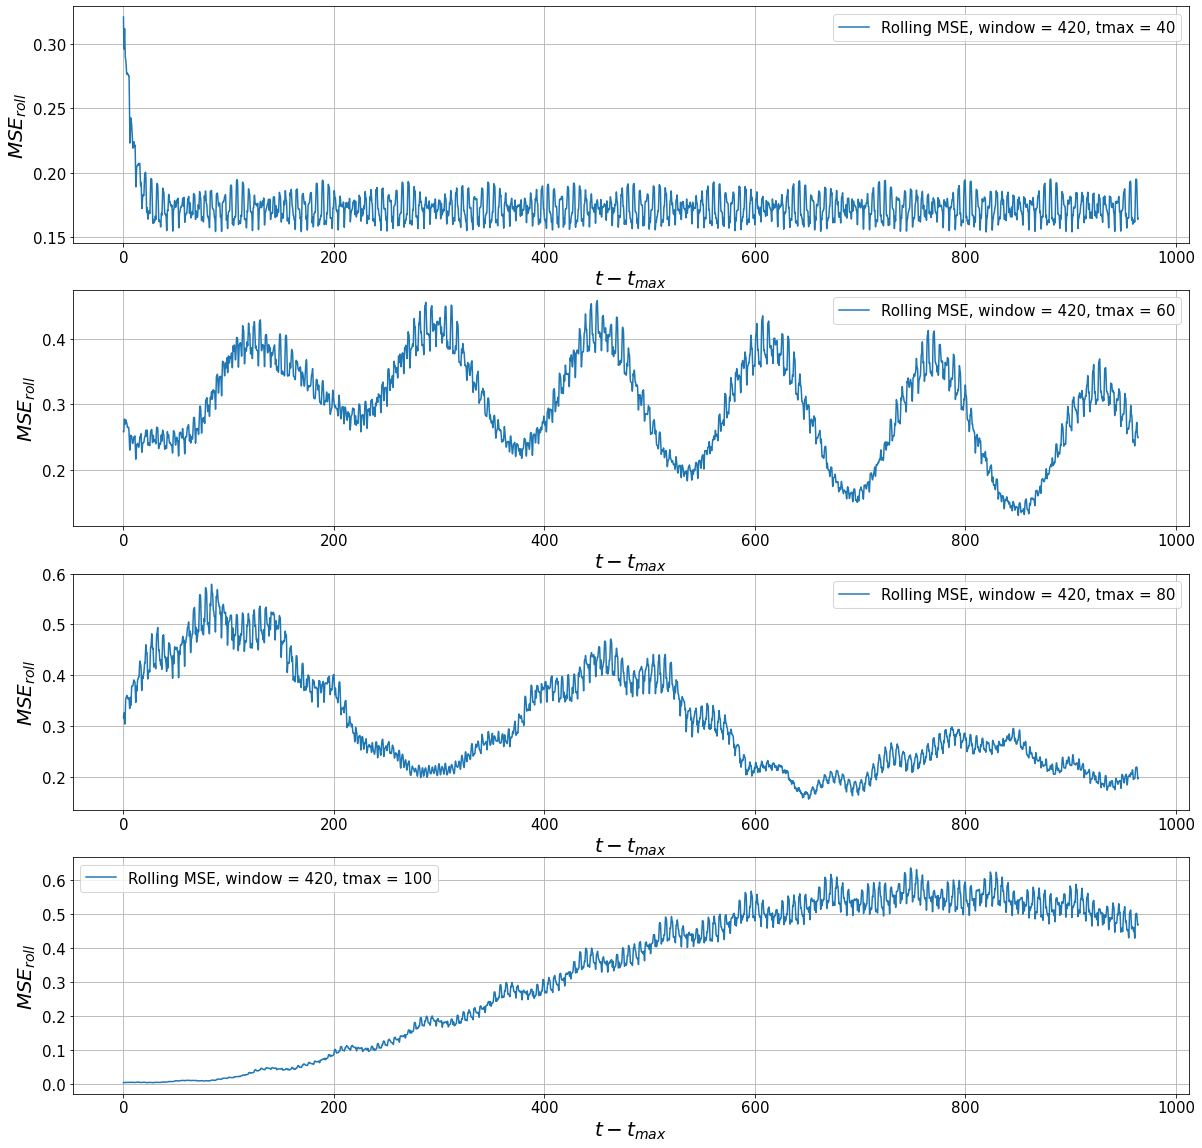

In [134]:
N = 420#21

roll_means = []
roll_mean_times = []

with plt.rc_context({'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    fig, ax = plt.subplots(len(xmax), figsize = (20, 20))

    for i in range(len(xmax)):
        MSE_roll = (Ys[i, -(len(Ys[i])-LB):]-y_new)**2


        rolling_mean = np.convolve(MSE_roll, np.ones(N)/N, mode='valid')

        roll_means.append(rolling_mean)

        future_time = np.arange(0, len(rolling_mean)*dt, dt)
        roll_mean_times.append(future_time)

        ax[i].plot(future_time, rolling_mean, label = f'Rolling MSE, window = {N}, tmax = {xmax[i]}')


        ax[i].set_xlabel(r'$t-t_{max}$', fontsize = 20)
        ax[i].set_ylabel(r'$MSE_{roll}$', fontsize = 20)

        ax[i].tick_params(labelsize = 15)

        ax[i].grid(visible = True)

        ax[i].legend(fontsize = 15)
        #plt.savefig('fig1_8.png', format = 'png', bbox_inches = 'tight')
        #ax[i].set_xlim(0, 600)

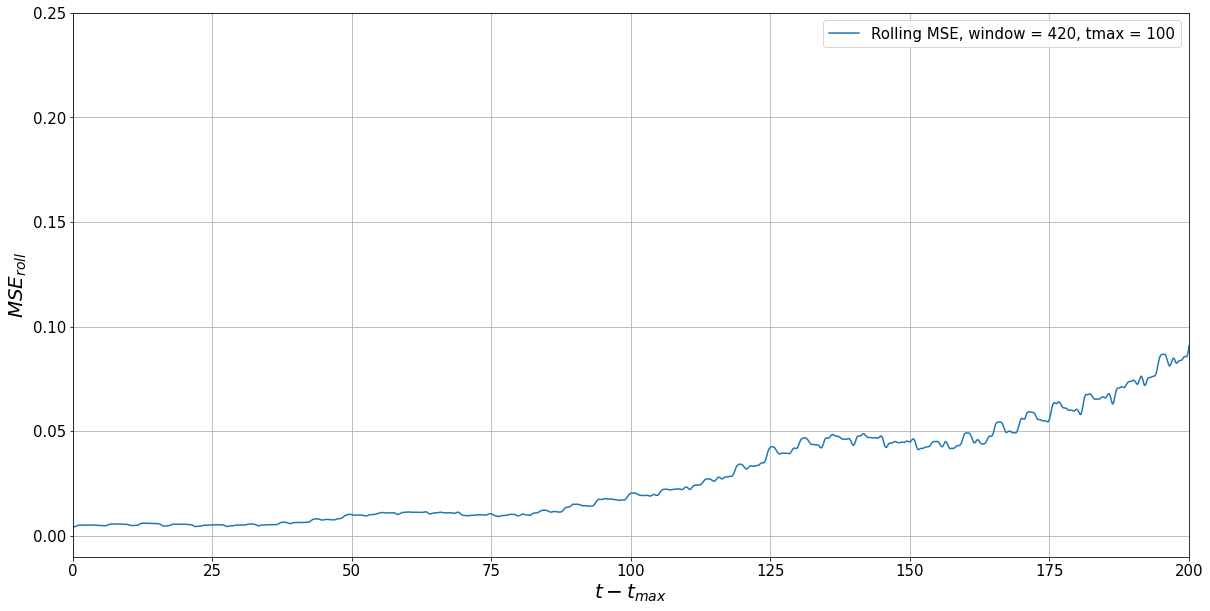

In [135]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    fig = plt.figure(figsize = (20, 10))

    plt.plot(roll_mean_times[-1], roll_means[-1], label = f'Rolling MSE, window = {N}, tmax = {xmax[-1]}')

    plt.xlabel(r'$t-t_{max}$', fontsize = 20)
    plt.ylabel(r'$MSE_{roll}$', fontsize = 20)

    plt.tick_params(labelsize = 15)

    plt.grid(visible = True)

    plt.legend(fontsize = 15)

    plt.xlim(0, 200)
    plt.ylim(-0.01, 0.25)
    plt.savefig('fig1_10.png', format = 'png', bbox_inches = 'tight')

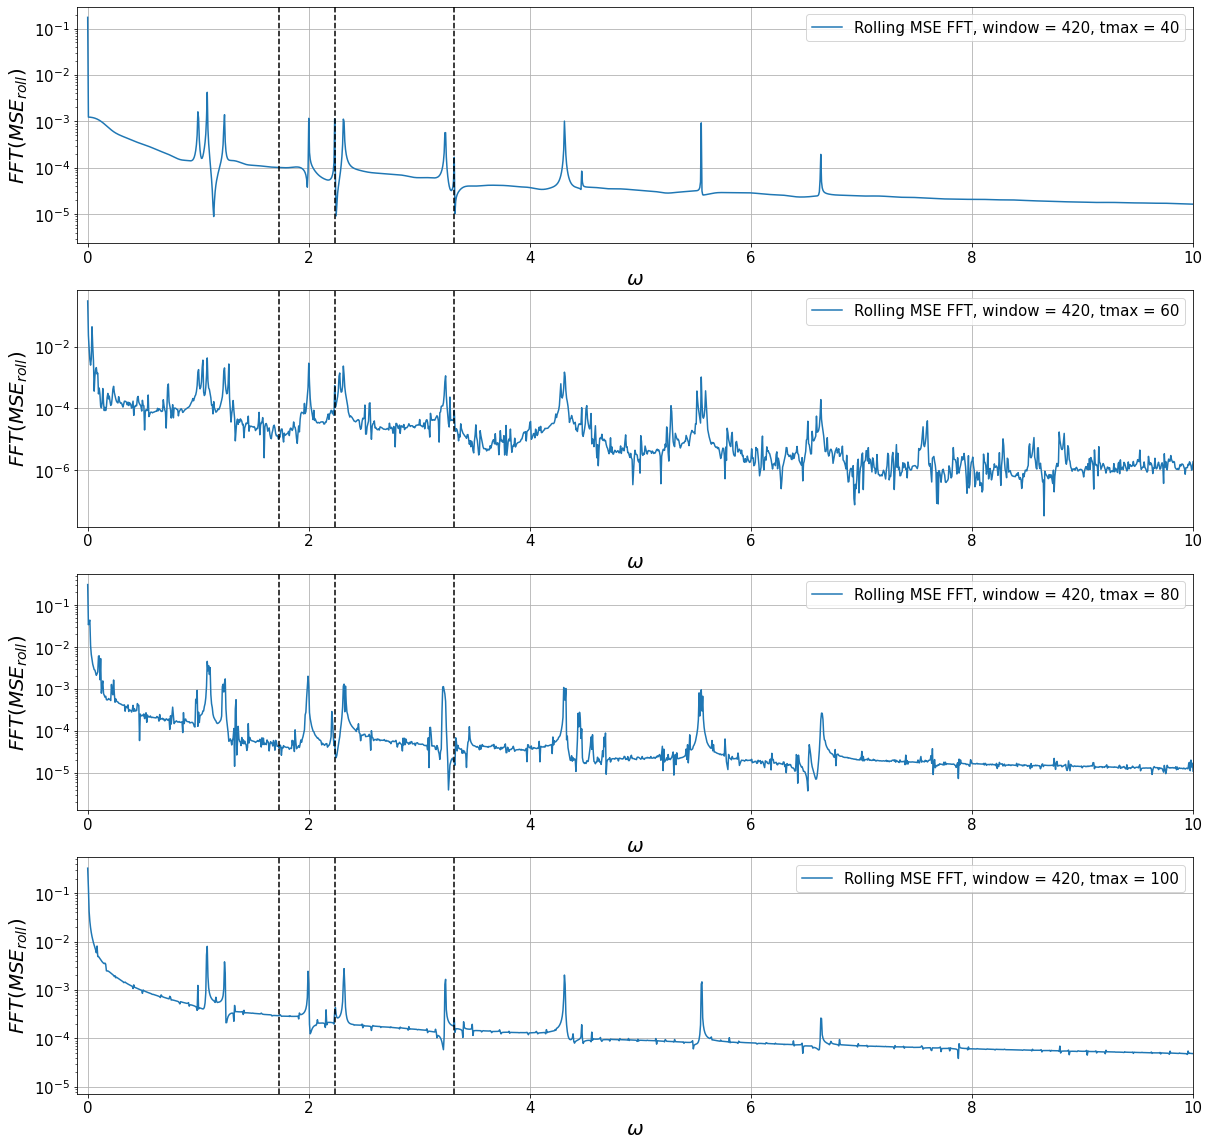

In [137]:
from numpy.fft import fft, fftfreq

Fs = 1/dt


with plt.rc_context({'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    fig, ax = plt.subplots(len(xmax), figsize = (20, 20))
    for i in range(len(xmax)):
        df = Fs/len(roll_means[i])

        freqs = 2*np.pi*np.linspace(0, (len(roll_means[i])-1)*df, len(roll_means[i]))

        Yfft = np.abs(fft(roll_means[i]))/len(roll_means[i])

        ax[i].semilogy(freqs, Yfft, label = f'Rolling MSE FFT, window = {N}, tmax = {xmax[i]}')

        ax[i].set_xlabel(r'$\omega$', fontsize = 20)
        ax[i].set_ylabel(r'$FFT(MSE_{roll})$', fontsize = 20)

        ax[i].tick_params(labelsize = 15)

        ax[i].grid(visible = True)

        ax[i].axvline(x = np.sqrt(11), c = 'black', linestyle = 'dashed')
        ax[i].axvline(x = np.sqrt(5), c = 'black', linestyle = 'dashed')
        ax[i].axvline(x = np.sqrt(3), c = 'black', linestyle = 'dashed')

        ax[i].legend(fontsize = 15)
        ax[i].set_xlim(-0.1, 10)
        #ax[i].set_ylim(-0.01, 0.1)
        #plt.savefig('fig1_9.png', format = 'png', bbox_inches = 'tight')

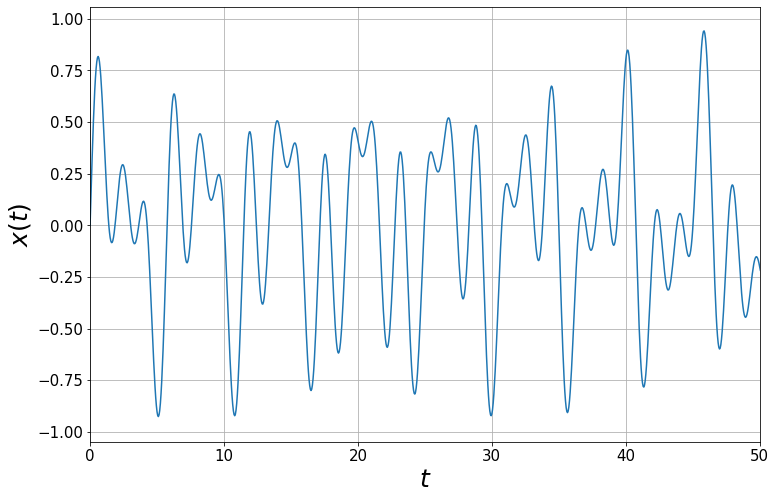

In [10]:
x_new1 = np.arange(0, 140 - 200*0.05, 0.05)

y_new1 = Inc_Signals(A, fs, x_new1)
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    fig = plt.figure(figsize = (12, 8))
    plt.plot(x_new1, y_new1)
    #plt.plot(x_new-0.05*200, Ys[-1, 0, :, 0])

    plt.xlabel(r'$t$', fontsize = 25)
    plt.ylabel(r'$x(t)$', fontsize = 25)

    plt.tick_params(labelsize = 15)

    plt.grid(visible = True)

    plt.xlim(0, 50)

    plt.savefig('y_actual.png', format = 'png', bbox_inches = 'tight')

"\nextrapolation = np.array(extrapolation)\n\n%matplotlib inline\nfig = plt.figure(figsize = (12, 8))\n\n#ax[0].set_title('Parte real', fontsize = 15)\nplt.plot(x_new, y_new, label = 'Exato (numérico)')\nplt.plot(x_ext-3*lb*0.05, extrapolation[0,:,0], '--', c='r', label = 'Previsão')\nplt.axvline(x=x[-1], color = 'g')\n\nplt.tick_params(labelsize=20)\n\nplt.legend(loc = 0)\n\nplt.xlabel('t', fontsize = 25)\n\n\nplt.show()\n"